<a href="https://colab.research.google.com/github/japerego/DroidCafe/blob/master/Proyecto_3_3_Ajuste_de_Hiperpar%C3%A1metros_Modelos_Multiclase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- *Alumno*:
- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2021/2022
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 3. Parte 3. Ajuste de Hiperparámetros en Modelos Multiclase

La búsqueda de los hiperparámetros óptimos de un modelo es un trabajo tedioso y que supone un coste computacional elevado, sobretodo si los modelos se construyen con bases de datos grandes. Existen diversas formas de realizar esta tarea. Habitualmente, las formas más comunes son las siguientes:

- **Ajuste del hiperparámetro uno a uno**. Se elige el hiperparámetro que afecta más a la precisión del modelo, habitualmente suelen ser hiperparámetros que tienen que ver con el tamaño del modelo (cómo el número de neuronas ocultas en redes neuronales, la profundidad del árbol, el número de K vecinos, o el número de árboles en RandomForest o Gradient Boosting Machines) o que tengan que ver con la velocidad del aprendizaje (como el learning rate en gradient boosting machines). Posteriormente, se ajustan otros parámetros que permiten afinar más el ajuste. Este método, suele ser una buena opción para reducir los tiempos pero es muy importante conocer cada uno de los hiperparámetros de un modelo.
- **Ajuste en Rejilla**. Es muy exhaustivo pero costoso computacionalmente. No recomendable con más de 3 hiperparámetros. Habitualmente, se comienza con rejillas con pasos grandes y se va repiendo la rejilla con pasos más finos en la zona donde se obtienen los mejores modelos.
- **Método Aleatorio**. Se realiza una busqueda aleatoria dentro de los rangos de los hiperparámetros y se va reduciendo los rangos donde se observan mejores modelos.
- **Método Bayesiano**. Basado en modelos bayesianos que tratan de encontrar los mejores hiperparámetros en base a los anteriores.
- **Métodos de Optimización Evolutivos como, por ejemplo, los Algoritmos Genéticos o basados en Enjambre de Partículas**. Son muy costosos computacionalmente pero pueden encontrar soluciones muy precisas.

Aunque este proceso puede automatizarse **es muy importante entender que la búsqueda de los mejores modelos en un proyecto de machine learning depende de muchos factores que corresponden al KDD**: la calidad de la información, el preprocesado y limpieza de los datos, la selección e importancia de las características, la selección correcta de la métrica, el proceso de validación de los modelos, etc. Es por ello, que el éxito en la creación de los modelos depende de muchos factores previos.

Así mismo, es **muy importante entender qué hace cada hiperparámetro en un modelo, para qué sirve y cuál es su cometido**.

In [1]:
!pip install bayesian-optimization
!pip install lightgbm
!pip install xgboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=ad7b25b076409e476c2e6deafa5129d1d60a9896440a6ef73d08dbd5864f6531
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 53 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
# from tqdm.notebook import tqdm
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression

from bayes_opt import BayesianOptimization

from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# %matplotlib inline
plt.style.use('ggplot')
# Elimina la limitación en visualización del numero de columnas
pd.set_option('display.max_columns', None) 

## Cargamos la Base de Datos

In [3]:
!wget https://github.com/IC1920/Datasets/raw/master/train.zip -O train.zip
!wget https://github.com/IC1920/Datasets/raw/master/test.zip -O test.zip
!unzip -o train.zip
!unzip -o test.zip

--2022-05-28 15:14:29--  https://github.com/IC1920/Datasets/raw/master/train.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip [following]
--2022-05-28 15:14:29--  https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1655239 (1.6M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   1.58M  --.-KB/s    in 0.06s   

2022-05-28 15:14:29 (27.5 MB/s) - ‘train.zip’ saved [1655239/1655239]

--2022-05-28 15:14:30--  https://github.com/IC1920/Datasets/raw/master/test.zip

In [4]:
# Leemos los archivos arff
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

features = ['feat_'+str(i) for i in np.arange(1,94)]
target = 'target'

(61878, 95) (144368, 94)


## Preprocesado de la Base de Datos

Aunque a los árboles no les suele afectar en demasía que las variables tengan diferentes rangos, vamos a tipificar los datos con *Z-Score* para si vamos a usar otros algoritmos supervisados, como KNN, o no supervisados, como clústering.

In [5]:
scaler = StandardScaler()
X_train = df_train[features].values.copy()
X_test = df_test[features].values.copy()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Preparamos las bases de datos. Para poder hacer una validación local, extraemos un 20% de forma aleatoria de forma estratificada.

In [6]:
X = X_train_scaled
y = df_train[target].values.reshape(-1)
y = LabelEncoder().fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=36, stratify=y)

print("Verificamos que la partición es estratificada")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_val)/len(y_val),3))

Verificamos que la partición es estratificada
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]


In [7]:
def entrena_model_hold_out(model, calibra=True):
    np.random.seed(2020)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds_val = calibrated_clf.predict_proba(X_val)
    else:
        model.fit(X_train, y_train)
        preds_val = model.predict_proba(X_val)

    # Extrae las métricas
    log_loss_val = log_loss(y_val, preds_val, eps=1e-15, normalize=True)
    return log_loss_val

Con fines didácticos, vamos a hacer una búsqueda simple del número de árboles.

**ATENCION: El coste computacional de las búsqueda de los mejores Hiperparámetros de los modelos es elevado. NO EJECUTAR EL CALCULO SI NO SE DISPONE DE UN EQUIPO LOCAL DE ALTAS PRESTACIONES.**

  0%|          | 0/11 [00:00<?, ?it/s]

n_estimators=200 log_loss_val=0.4876483509319149
n_estimators=300 log_loss_val=0.4858656407676537
n_estimators=400 log_loss_val=0.48496375036777034
n_estimators=500 log_loss_val=0.4869548356135196
n_estimators=600 log_loss_val=0.48462076575304075
n_estimators=700 log_loss_val=0.48475844473067925
n_estimators=800 log_loss_val=0.4851488831184257
n_estimators=900 log_loss_val=0.4868171530945908
n_estimators=1000 log_loss_val=0.4866869712319184
n_estimators=1100 log_loss_val=0.48678893450104727
n_estimators=1200 log_loss_val=0.48480643019250264
Mejor n_estimator=600
Wall time: 18min 53s


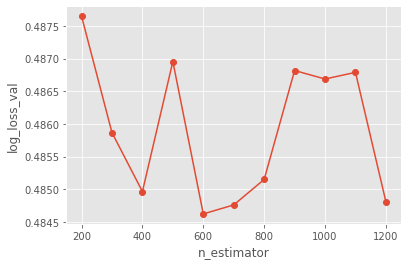

In [ ]:
%%time
scores = []
lestimators = np.arange(200,1300,100)
for n_estimators in tqdm(lestimators):
    rf_model = RandomForestClassifier(n_estimators=n_estimators,n_jobs=-1, random_state=1234)
    log_loss_val = entrena_model_hold_out(rf_model, calibra=True)
    print(f'n_estimators={n_estimators} log_loss_val={log_loss_val}')
    scores.append(log_loss_val)

plt.plot(lestimators,scores,'o-')
plt.ylabel('log_loss_val')
plt.xlabel("n_estimator")
print(f'Mejor n_estimator={lestimators[np.argmin(scores)]}')

Vemos que a el menor error se obtiene con 600 árboles. Vamos a ver si controlando el tamaño de los árboles podemos mejorar. En este caso, vamos a ajustar *min_samples_split* que corresponde con el numero minimo de muestras requeridas para poder dividir un nodo. 

  0%|          | 0/3 [00:00<?, ?it/s]

min_samples_split=2 log_loss_val=0.48462076575304075
min_samples_split=3 log_loss_val=0.4859706843580878
min_samples_split=4 log_loss_val=0.48785412283958773
Mejor min_samples_split=2 log_loss_val=0.48462076575304075
Wall time: 4min 14s


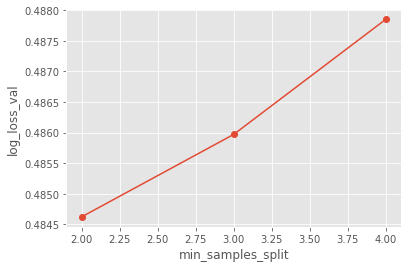

In [ ]:
%%time
scores = []
lminsplit = np.arange(2,5)
for minsplit in tqdm(lminsplit):
    rf_model = RandomForestClassifier(min_samples_split=minsplit,
                                      n_estimators=600,
                                      n_jobs=-1,
                                      random_state=1234)
    log_loss_val = entrena_model_hold_out(rf_model, calibra=True)
    print(f'min_samples_split={minsplit} log_loss_val={log_loss_val}')
    scores.append(log_loss_val)
    
plt.plot(lminsplit,scores,'o-')
plt.ylabel('log_loss_val')
plt.xlabel("min_samples_split")
print(f'Mejor min_samples_split={lminsplit[np.argmin(scores)]} log_loss_val={np.min(scores)}')

Vamos a ver si ampliando o reduciendo el número de atributos podemos mejorar levemente el error. Por defecto, RF usa *sqrt(len(features))=9.64=9* features.

  0%|          | 0/6 [00:00<?, ?it/s]

max_features=6 log_loss_val=0.4933685442522172
max_features=7 log_loss_val=0.49042836718750865
max_features=8 log_loss_val=0.48508826561638274
max_features=9 log_loss_val=0.48462076575304075
max_features=10 log_loss_val=0.4882799111015216
max_features=11 log_loss_val=0.486590386451606
Mejor max_features 9
Wall time: 8min 24s


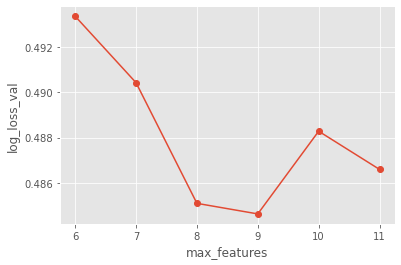

In [ ]:
%%time
scores = []
lfeatures = np.arange(6,12)
for max_features in tqdm(lfeatures):
    rf_model = RandomForestClassifier(max_features=max_features,
                                      n_estimators=600,
                                      min_samples_split=2,
                                      n_jobs=-1,
                                      random_state=1234)
    log_loss_val = entrena_model_hold_out(rf_model, calibra=True)
    print(f'max_features={max_features} log_loss_val={log_loss_val}')
    scores.append(log_loss_val)
    
plt.plot(lfeatures,scores,'o-')
plt.ylabel('log_loss_val')
plt.xlabel("max_features")
print(f'Mejor max_features {lfeatures[np.argmin(scores)]}')

No hay cambios. Afinamos ahora el numero de arboles final.

  0%|          | 0/7 [00:00<?, ?it/s]

n_estimators=525 log_loss_val=0.48487162927019983
n_estimators=550 log_loss_val=0.4847339404823144
n_estimators=575 log_loss_val=0.4846981127832806
n_estimators=600 log_loss_val=0.48462076575304075
n_estimators=625 log_loss_val=0.4849201153785705
n_estimators=650 log_loss_val=0.48460451402401566
n_estimators=675 log_loss_val=0.48476489900470854
Mejor n_estimator=650
Wall time: 10min 8s


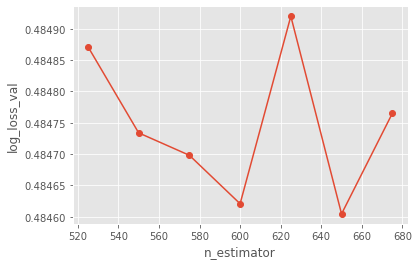

In [ ]:
%%time
scores = []
lestimators = np.arange(525,700,25)
for n_estimators in tqdm(lestimators):
    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                      min_samples_split=2,
                                      max_features=9,
                                      n_jobs=-1,
                                      random_state=1234)
    log_loss_val = entrena_model_hold_out(rf_model, calibra=True)
    print(f'n_estimators={n_estimators} log_loss_val={log_loss_val}')
    scores.append(log_loss_val)
    
plt.plot(lestimators,scores,'o-')
plt.ylabel('log_loss_val')
plt.xlabel("n_estimator")
print(f'Mejor n_estimator={lestimators[np.argmin(scores)]}')

**La configuración final es:**

- n_estimators=650
- min_samples_split=2
- max_features=9

**con un log_loss=0.48460451402401566**

## Modelo Logístico

Probamos un primer modelo Logistic

In [ ]:
%%time
logistic_model = LogisticRegression(n_jobs=-1,class_weight=None,random_state=42)
log_loss_val = entrena_model_hold_out(logistic_model, calibra=False)
print(f'log_loss_val={log_loss_val}')

log_loss_val=0.6399495176954089


In [ ]:
%%time
logistic_model = LogisticRegression(n_jobs=-1,class_weight=None,random_state=42)
log_loss_val = entrena_model_hold_out(logistic_model, calibra=True)
print(f'log_loss_val={log_loss_val}')

log_loss_val=0.9080750998107069


Vemos que la calibración no mejora la predicción. Probamos con el calibrado con *sigmoid*

In [ ]:
%%time
logistic_model = LogisticRegression(n_jobs=-1,class_weight=None,random_state=42)
calibrated_clf = CalibratedClassifierCV(logistic_model, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)
preds_val = calibrated_clf.predict_proba(X_val)
log_loss_val = log_loss(y_val, preds_val, eps=1e-15, normalize=True)
print(f'log_loss_val={log_loss_val}')

log_loss_val=1.0376368752677683


En este caso, debemos prescindir del calibrado en el modelo logistico.

Ahora, vamos a ver cual es el mejor numero de iteraciones en el proceso de optimización del modelo logstico.

max_iter=100 log_loss_val=0.6399495176954089
max_iter=150 log_loss_val=0.6389617295064111
max_iter=200 log_loss_val=0.6388004360079969
max_iter=250 log_loss_val=0.6386921703724855
max_iter=300 log_loss_val=0.6385755076273876
max_iter=350 log_loss_val=0.6386158769814523
max_iter=400 log_loss_val=0.6385800277106308
max_iter=450 log_loss_val=0.638554209840292
max_iter=500 log_loss_val=0.6385569270373685
max_iter=550 log_loss_val=0.6385569270373685
max_iter=600 log_loss_val=0.6385569270373685
max_iter=650 log_loss_val=0.6385569270373685
max_iter=700 log_loss_val=0.6385569270373685
max_iter=750 log_loss_val=0.6385569270373685

Logistic Mejor max_iter=450 score=0.638554209840292


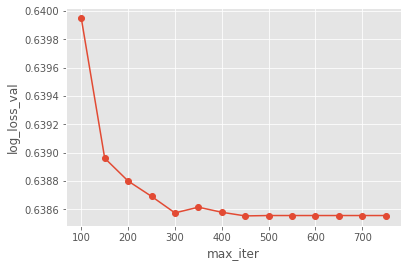

In [ ]:
%%time
scores = []
lmax_iter = np.arange(100,800,50)
for maxi in tqdm(lmax_iter):
    logistic_model = LogisticRegression(max_iter=maxi,n_jobs=-1,class_weight=None,random_state=42)
    log_loss_val = entrena_model_hold_out(logistic_model, calibra=False)
    print(f'max_iter={maxi} log_loss_val={log_loss_val}')
    scores.append(log_loss_val)
    
plt.plot(lmax_iter,scores,'o-')
plt.ylabel('log_loss_val')
plt.xlabel("max_iter")
print(f'Logistic Mejor max_iter={lmax_iter[np.argmin(scores)]} score={np.min(scores)}')

Ahora ajustamos el Parámetro C que es similar al parámetro de complejidad de las SVM

C=0.0625 log_loss_val=0.6430509928212406
C=0.125 log_loss_val=0.6404098634455558
C=0.25 log_loss_val=0.6392146686087529
C=0.5 log_loss_val=0.63873858177
C=1.0 log_loss_val=0.638554209840292
C=2.0 log_loss_val=0.6385452248171362
C=4.0 log_loss_val=0.6385719812867574
C=8.0 log_loss_val=0.6386509957125119

Logistic Mejor C=2.0 score=0.6385452248171362


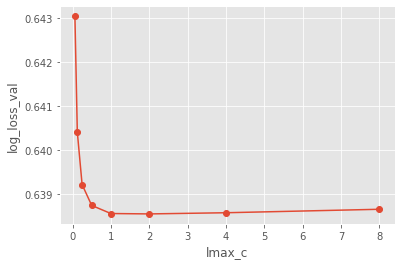

In [ ]:
%%time
scores = []
lmax_c = np.power(2.0,np.arange(-4,4,1))
for c_value in tqdm(lmax_c):
    logistic_model = LogisticRegression(C=c_value, max_iter=450, 
                                        n_jobs=-1,class_weight=None,random_state=42)
    log_loss_val = entrena_model_hold_out(logistic_model, calibra=False)
    print(f'C={c_value} log_loss_val={log_loss_val}')
    scores.append(log_loss_val)
    
plt.plot(lmax_c,scores,'o-')
plt.ylabel('log_loss_val')
plt.xlabel("lmax_c")
print(f'Logistic Mejor C={lmax_c[np.argmin(scores)]} score={np.min(scores)}')

**El mejor modelo logistico se obtiene con:**

- max_iter=450
- C=2.0

**con log_loss_val=0.6385452248171362**

## Modelo: XGBoost

Extreme Gradient Machines (*XGBoost*) es uno de los algoritmos más populares de *Gradient Boosting Machines* 

In [ ]:
# Parametros que vienen por defecto
parametros = {'learning_rate':0.1, 'n_estimators':100, 'max_depth':6,
              'subsample':0.80, 'colsample_bytree':0.80,
              'reg_alpha':0.0, 'reg_lambda':1.0}

In [ ]:
def busca_param(valores, nombre_var, parametros):
    scores = []
    for valor in tqdm(valores):
        parametros[nombre_var]=valor
        xgb_model = XGBClassifier(learning_rate=parametros['learning_rate'],
                                  n_estimators=parametros['n_estimators'],
                                  max_depth=parametros['max_depth'],
#                                   min_child_weight=parametros['min_child_weight'],
                                  subsample=parametros['subsample'],
                                  colsample_bytree=parametros['colsample_bytree'],
                                  reg_alpha=parametros['reg_alpha'], 
                                  reg_lambda=parametros['reg_lambda'],
                                  nthread=20,
                                  seed=42, objective='multi:softprob')
        log_loss_val = entrena_model_hold_out(xgb_model, calibra=True)
        print(f'{nombre_var}={valor} log_loss_val={log_loss_val}')
        scores.append(log_loss_val)
    plt.plot(valores,scores,'o-')
    plt.ylabel('log_loss_val')
    plt.xlabel(nombre_var)
    print(f'Mejor {nombre_var}={valores[np.argmin(scores)]} Score={np.min(scores)}')
    return valores[np.argmin(scores)]

n_estimators=300 log_loss_val=0.46736178529866623
n_estimators=400 log_loss_val=0.45926067834433654
n_estimators=500 log_loss_val=0.4536980114976586
n_estimators=600 log_loss_val=0.45209586060964246
n_estimators=700 log_loss_val=0.45091114003355104
n_estimators=800 log_loss_val=0.4507638376995122
n_estimators=900 log_loss_val=0.45255563600555726
n_estimators=1000 log_loss_val=0.45249268509066576

Mejor n_estimators=800 Score=0.4507638376995122
{'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


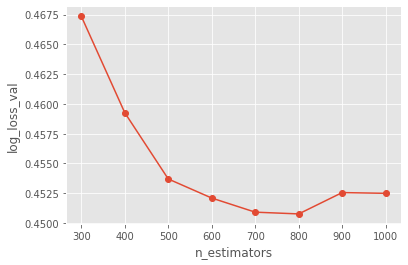

In [ ]:
%%time
# Busqueda del numero de arboles
parametros['n_estimators'] = busca_param(np.arange(300,1100,100), 'n_estimators', parametros)
print(parametros)

max_depth=2 log_loss_val=0.5323584298971848
max_depth=3 log_loss_val=0.49199263580225383
max_depth=4 log_loss_val=0.47115790516004863
max_depth=5 log_loss_val=0.4577353556461342
max_depth=6 log_loss_val=0.4507638376995122
max_depth=7 log_loss_val=0.4550300553429426
max_depth=8 log_loss_val=0.4505095069917167
max_depth=9 log_loss_val=0.4527971217745995
max_depth=10 log_loss_val=0.4550837451364092
max_depth=11 log_loss_val=0.4567573052688949
max_depth=12 log_loss_val=0.4564085862141767

Mejor max_depth=8 Score=0.4505095069917167
{'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


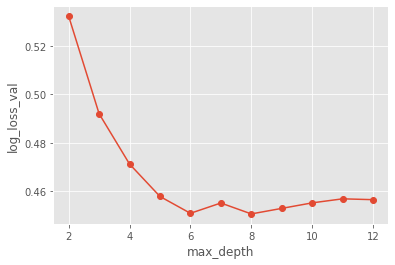

In [ ]:
%%time
# Maxima profundidad
parametros['max_depth'] = busca_param(np.arange(2,13), 'max_depth', parametros)
print(parametros)

In [ ]:
# # Minimos Pesos por particion
# parametros['min_child_weight'] = busca_param(np.arange(1,6), 'min_child_weight', parametros)
# print(parametros)

subsample=0.5 log_loss_val=0.4551344902532299
subsample=0.6 log_loss_val=0.45325106123479286
subsample=0.7 log_loss_val=0.4533673977116736
subsample=0.8 log_loss_val=0.4505095069917167
subsample=0.9 log_loss_val=0.4526932200720692
subsample=1.0 log_loss_val=0.4555757173214048

Mejor subsample=0.8 Score=0.4505095069917167
{'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


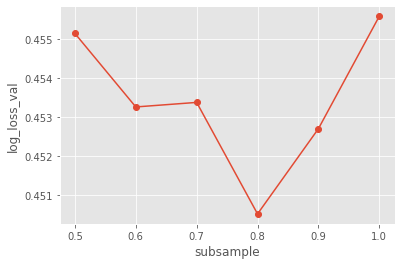

In [ ]:
%%time
# Subsample
parametros['subsample'] = busca_param(np.arange(5,11)/10.0, 'subsample', parametros)
print(parametros)

colsample_bytree=0.1 log_loss_val=0.4732905706034286
colsample_bytree=0.2 log_loss_val=0.4571016650054453
colsample_bytree=0.3 log_loss_val=0.45353415645348066
colsample_bytree=0.4 log_loss_val=0.45148788998485495
colsample_bytree=0.5 log_loss_val=0.4547330360844201
colsample_bytree=0.6 log_loss_val=0.44995794392902055
colsample_bytree=0.7 log_loss_val=0.45199918147748414
colsample_bytree=0.8 log_loss_val=0.4505095069917167
colsample_bytree=0.9 log_loss_val=0.4536114309956032
colsample_bytree=1.0 log_loss_val=0.4565975889517779

Mejor colsample_bytree=0.6 Score=0.44995794392902055
{'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


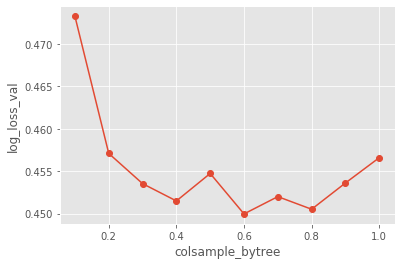

In [ ]:
%%time
# Colsample_bytree
parametros['colsample_bytree'] = busca_param(np.arange(1,11)/10.0, 'colsample_bytree', parametros)
print(parametros)

reg_alpha=0.0 log_loss_val=0.44995794392902055
reg_alpha=0.0001 log_loss_val=0.4493313911857783
reg_alpha=0.001 log_loss_val=0.44870034989651664
reg_alpha=0.01 log_loss_val=0.45145810496523026
reg_alpha=0.1 log_loss_val=0.45255335141241976
reg_alpha=1.0 log_loss_val=0.4537183277611617
reg_alpha=5 log_loss_val=0.4560511022253273
reg_alpha=10 log_loss_val=0.47011653821353017

Mejor reg_alpha=0.001 Score=0.44870034989651664
{'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 0.001, 'reg_lambda': 1.0}


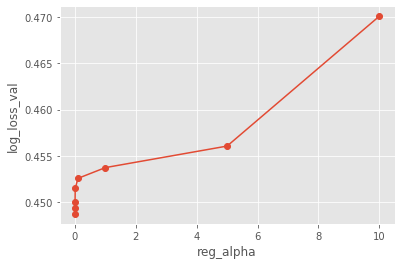

In [ ]:
%%time
# Probamos con Regularización L1
parametros['reg_alpha'] = busca_param([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 5, 10], 'reg_alpha', parametros)
print(parametros)

reg_lambda=0.0 log_loss_val=0.45055427640048595
reg_lambda=0.0001 log_loss_val=0.45076640112934196
reg_lambda=0.001 log_loss_val=0.45021311011560045
reg_lambda=0.01 log_loss_val=0.4506474823400529
reg_lambda=0.1 log_loss_val=0.44995383668184963
reg_lambda=1.0 log_loss_val=0.44870034989651664
reg_lambda=5 log_loss_val=0.45082358768638486
reg_lambda=10 log_loss_val=0.45149529570777125

Mejor reg_lambda=1.0 Score=0.44870034989651664
{'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 0.001, 'reg_lambda': 1.0}


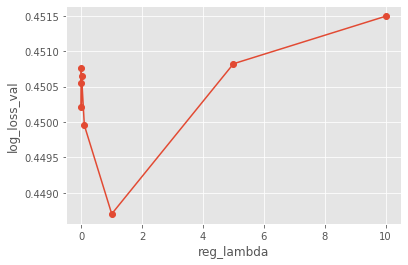

In [ ]:
%%time
# Probamos con Regularización L2
parametros['reg_lambda'] = busca_param([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 5, 10], 'reg_lambda', parametros)
print(parametros)

learning_rate=0.001 log_loss_val=0.5915441456807554
learning_rate=0.005 log_loss_val=0.5386951453043503
learning_rate=0.01 log_loss_val=0.4998207269911845
learning_rate=0.05 log_loss_val=0.4489437128075007
learning_rate=0.1 log_loss_val=0.44870034989651664
learning_rate=0.15 log_loss_val=0.4522763014563908
learning_rate=0.2 log_loss_val=0.45746889298573384
learning_rate=0.25 log_loss_val=0.4615933382198224
learning_rate=0.3 log_loss_val=0.4672680293476639

Mejor learning_rate=0.1 Score=0.44870034989651664
{'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 0.001, 'reg_lambda': 1.0}


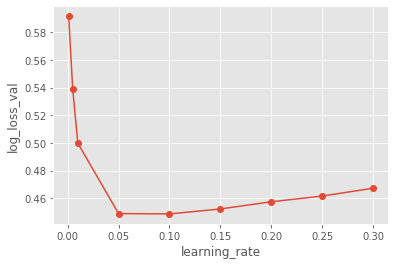

In [ ]:
%%time
# Learning rate
parametros['learning_rate'] = busca_param([0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'learning_rate', parametros)
print(parametros)

n_estimators=650 log_loss_val=0.44793749417581175
n_estimators=675 log_loss_val=0.4499451487445979
n_estimators=700 log_loss_val=0.45026205268982383
n_estimators=725 log_loss_val=0.45039045940757955
n_estimators=750 log_loss_val=0.4483690096247282
n_estimators=775 log_loss_val=0.4485648129319966
n_estimators=800 log_loss_val=0.44870034989651664
n_estimators=825 log_loss_val=0.44900210664792517
n_estimators=850 log_loss_val=0.44918294153707755
n_estimators=875 log_loss_val=0.449669351113557
n_estimators=900 log_loss_val=0.4498913652612586
n_estimators=925 log_loss_val=0.4502654881024376

Mejor n_estimators=650 Score=0.44793749417581175
{'learning_rate': 0.1, 'n_estimators': 650, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.6, 'reg_alpha': 0.001, 'reg_lambda': 1.0}


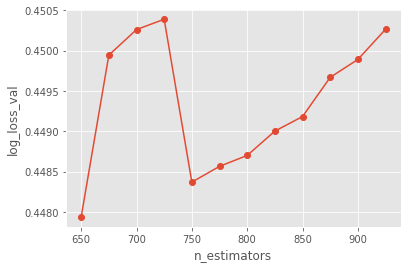

In [ ]:
%%time
# Busqueda fina del numero de arboles a partir del mejor
parametros['n_estimators'] = busca_param(np.arange(parametros['n_estimators']-150,parametros['n_estimators']+150,25),
                                         'n_estimators', parametros)
print(parametros)

**El mejor modelo XGBoost se obtiene con:**

- 'learning_rate': 0.1
- 'n_estimators': 650
- 'max_depth': 8
- 'subsample': 0.8
- 'colsample_bytree': 0.6
- 'reg_alpha': 0.001
- 'reg_lambda': 1.0

**con log_loss_val=0.44793749417581175**

## ¿Somos capaces de mejorar estos resultados con Optimización Bayesiana?

Los modelos *Ensemble*, disponen habitualmente de múltiples parámetros que suelen ser difíciles de ajustar. Este problema es conocido como *Optimización de Hyperparámetros* o *Hyperparameter Optimization (HO)*.

Cuando el proceso de entrenamiento de los modelos es costoso computacionalmente, es conveniente utilizar estrategias de HO más avanzadas que las clásicas *GridSeach* o *RandomSearch*. 

Uno de los métodos más usados habitualmente para HO, usado por muchas herramientas de *Machine Learning Optimization* (AutoML, AutoKeras, etc.), es la *[Optimización Bayesiana (OB)](https://github.com/fmfn/BayesianOptimization/)*. 

**La OB debe ser utilizada con cuidado pues no es un método milagroso y puede darnos peores resultados que la búsqueda manual o clásica. Es muy importante seleccionar parámetros del modelo que QUE ESTÉN RELACIONADOS ENTRE SI LO MENOS POSIBLE.**

Por ejemplo, si elegimos ajustar los tres parámetros de un RF que tienen que ver con limitaciones en el crecimiento de los árboles:
- 'max_depth': Máxima profundidad de cada  arbol
- 'min_samples_split': Mínimo número de ejemplos para generar una división
- 'min_samples_leaf': Mínimo número de elementos que puede tener una hoja
es probable que el proceso de optimización no sea eficiente. Lo mismo lo podemos aplicar a otros modelos basados en combinación de árboles como *XGBoost*, *LightGBM* o *Catboost*
            

"Este proceso combina 4 pasos ([ref](https://www.buguroo.com/es/blog/optimizacion-de-hiperparametros)):
- Elegir alguna medida previa en el espacio de posibles funciones de métodos de evaluación. Como se desconoce nuestra función objetiva (métrica de evaluación sobre la función de configuraciones), este paso supone tratarla como una función aleatoria con una distribución previa seleccionada. Esto captura nuestras creencias sobre el comportamiento de la función (ej., a menudo se utiliza una distribución gaussiana multivariable).
- Combinar la distribución previa con algunas observaciones dadas (configuraciones probadas) para obtener una distribución posterior en el objetivo (estimación de dónde reside la verdadera función).
- Usar la distribución posterior para decidir dónde probar la siguiente configuración según alguna función de adquisición. Una función de adquisición es una herramienta que nos dice la configuración a probar en que se conseguirá la mayor cantidad de información.
- Evaluar la configuración seleccionada en el paso 3.

Después de haber probado algunas configuraciones iniciales (al menos 2) y haber concluido por primera vez todos los pasos, iterar entre 2 y 4 hasta que se activa el mecanismo de terminación y se cierra la optimización bayesiana.*



![](https://github.com/fmfn/BayesianOptimization/raw/master/examples/bo_example.png)

In [ ]:
%%time
# Vamos a buscar el mejor modelo con Bayesian Optimization
# Devolvemos el negativo de log_loss_val pues BO busca maximizar la metrica
from bayes_opt import BayesianOptimization

def bo_eval(max_depth, subsample, colsample_bytree, pow_alpha, pow_lambda):
    xgb_model = XGBClassifier(learning_rate=0.1,  #Fijamos el learning rate
                              n_estimators=800, #Fijamos el numero de arboles
                              max_depth=int(max_depth),
                              subsample=subsample,
                              colsample_bytree=colsample_bytree,
                              reg_alpha = 10.0**pow_alpha,
                              reg_lambda = 10.0**pow_lambda,
                              nthread=20,
                              seed=42, objective='multi:softprob')
    log_loss_val = entrena_model_hold_out(xgb_model, calibra=True)
    return -log_loss_val

# Buscamos mejor XGB
range_bo = {'max_depth': (2, 15),  #Máxima profundidad de cada  arbol
            'subsample': (0.1, 1.0), #Subsample
            'colsample_bytree': (0.1, 1.0), #Colsample
            'pow_alpha': (-4,3), # alpha=10**pow_alpha
            'pow_lambda': (-4,3), # lambda=10**pow_lambda
            }

BO_XGB = BayesianOptimization(bo_eval, range_bo, random_state=2020)
BO_XGB.maximize(init_points=6, n_iter=20)    
print('MEJOR XGB=',BO_XGB.max)

|   iter    |  target   | colsam... | max_depth | pow_alpha | pow_la... | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.4631   |  0.9876   |  13.35    | -0.4318   | -2.097    |  0.4032   |
|  2        | -0.5215   |  0.2953   |  5.594    | -1.597    |  2.035    |  0.241    |
|  3        | -0.5188   |  0.2268   |  11.84    |  1.154    | -1.51     |  0.407    |
|  4        | -0.4702   |  0.7001   |  4.822    | -0.07001  | -3.131    |  0.3878   |
|  5        | -0.5722   |  0.9579   |  3.786    | -0.01411  |  2.83     |  0.553    |
|  6        | -0.5302   |  0.7009   |  2.444    | -0.8072   | -2.909    |  0.5284   |
|  7        | -0.4894   |  0.1      |  15.0     | -4.0      | -4.0      |  1.0      |
|  8        | -0.5813   |  1.0      |  15.0     | -4.0      |  3.0      |  0.1      |
|  9        | -0.4768   |  1.0      |  8.314    | -4.0      | -4.0      |  0.1      |
|  10       | -1.95     |  1.0      |  15.0     |  3.0

Como se puede observar, aunque se llega a una solución aceptable, **BO no mejora a los resultados obtenidos con el proceso de busqueda planteado previamente**. Podrian eliminarse algunos parametros como *colsample_bytree* o *subsample* pues es posible que afecten al proceso de optimización, pero deberian luego ajustarse manualmente y el numero de iteraciones total sera parecido a la propuesta inicial de busqueda parametro a parametro.

## Enviamos la Submission de los Modelos

### Modelo RF Submission

**La configuración final fue:**
- n_estimators=600
- min_samples_split=2
- max_features=9

**con un Local log_loss=0.4818038439198601**

In [ ]:
%%time
rf_model = RandomForestClassifier(n_estimators=600,
                                  max_features=9,
                                  min_samples_split=2,
                                  n_jobs=-1,class_weight='balanced')
log_loss_val = entrena_model_hold_out(rf_model, calibra=True)
print(f'Mejor RF local log_loss_val={log_loss_val}')

Mejor RF local log_loss_val=0.4818038439198601


In [ ]:
%%time
# Creamos submission con toda la base de datos de entrenamiento
calibrated_clf = CalibratedClassifierCV(rf_model, method='isotonic', cv=5)
calibrated_clf.fit(X, y)
test_preds = calibrated_clf.predict_proba(X_test_scaled)

output = pd.DataFrame(test_preds,columns=["Class_"+str(i) for i in range(1,10)])
output.insert(loc=0, column='id', value=df_test.id)
output.to_csv('submission_rf.csv', index=False)
pd.read_csv('submission_rf.csv').head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.000229,0.127171,0.192283,0.668507,0.000082,0.001615,0.009459,0.000524,0.000130
1,2,0.004584,0.001983,0.001066,0.001300,0.000462,0.704477,0.002653,0.280276,0.003199
2,3,0.000142,0.000000,0.000000,0.000312,0.000000,0.998187,0.000177,0.001183,0.000000
3,4,0.000298,0.595608,0.364085,0.026133,0.000000,0.000000,0.000469,0.000643,0.012765
4,5,0.099618,0.000000,0.000000,0.000291,0.000045,0.003824,0.002219,0.226798,0.667205


Este modelo RF obtiene un **Local=0.48180, Private_LB=0.47250, Public_LB=0.46824**

### Modelo Logistic Submission

**El mejor modelo logistico se obtuvo con:**

- max_iter=450
- C=2.0

**con un local log_loss_val=0.6385452248171362**

In [ ]:
%%time
logistic_model = LogisticRegression(C=2.0, max_iter=450, n_jobs=-1,class_weight=None,random_state=42)
log_loss_val = entrena_model_hold_out(logistic_model, calibra=False)
print(f'Mejor modelo Logistico con local log_loss_val={log_loss_val}')    

Mejor modelo Logistico con local log_loss_val=0.6385452248171362


In [ ]:
%%time
# Creamos submission
logistic_model.fit(X, y)
test_preds = logistic_model.predict_proba(X_test_scaled)

output = pd.DataFrame(test_preds,columns=["Class_"+str(i) for i in range(1,10)])
output.insert(loc=0, column='id', value=df_test.id)
output.to_csv('submission_logistic.csv', index=False)
pd.read_csv('submission_logistic.csv').head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,9.618544e-06,1.585929e-01,2.511289e-01,5.858155e-01,7.194543e-14,8.493979e-06,4.444261e-03,2.609426e-07,1.497520e-08
1,2,4.382693e-04,3.352036e-05,2.077340e-07,2.078800e-08,8.526202e-07,6.731425e-01,2.238532e-04,3.249107e-01,1.250085e-03
2,3,3.274802e-06,1.998311e-08,5.220279e-09,2.056028e-11,4.407552e-11,9.998838e-01,4.455260e-05,6.772848e-05,6.607735e-07
3,4,6.774191e-10,7.115148e-01,2.818409e-01,6.643950e-03,1.826456e-09,1.082438e-08,9.998273e-08,2.599292e-09,1.821611e-07
4,5,6.624649e-01,2.215893e-07,5.720758e-08,2.347878e-09,2.313338e-16,4.724840e-03,1.163455e-03,4.139156e-02,2.902550e-01


Este modelo LOGISTICO obtiene un **Local=0.63855, Private_LB=0.63414, Public_LB=0.63382** que es mucho peor que el obtenido con el RF.

### Single XGB Submission

**El mejor modelo XGBoost se obtuvo con:**

- 'learning_rate': 0.1
- 'n_estimators': 650
- 'max_depth': 8
- 'subsample': 0.8
- 'colsample_bytree': 0.6
- 'reg_alpha': 0.001
- 'reg_lambda': 1.0

**con log_loss_val=0.44793749417581175**

In [ ]:
%%time
xgb_model = XGBClassifier(learning_rate =0.1, n_estimators=650, max_depth=8, 
                          subsample=0.8, colsample_bytree=0.6, nthread=20,
                          reg_alpha=0.001, reg_lambda=1.0,
                          seed=42, objective='multi:softprob')
log_loss_val = entrena_model_hold_out(xgb_model, calibra=True)
print(f'Best XGB con local log_loss_val={log_loss_val}')

Best XGB con local log_loss_val=0.44793749417581175


In [ ]:
%%time
# Creamos submission
calibrated_clf = CalibratedClassifierCV(xgb_model, method='isotonic', cv=5)
calibrated_clf.fit(X, y)
test_preds = calibrated_clf.predict_proba(X_test_scaled)

output = pd.DataFrame(test_preds,columns=["Class_"+str(i) for i in range(1,10)])
output.insert(loc=0, column='id', value=df_test.id)
output.to_csv('submission_xgb.csv', index=False)
pd.read_csv('submission_xgb.csv').head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.000043,0.203943,0.163291,0.627479,0.000000,0.000000,0.005041,0.000203,0.000000
1,2,0.001117,0.007269,0.001035,0.002142,0.000102,0.403497,0.010366,0.572735,0.001737
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.999858,0.000000,0.000142,0.000000
3,4,0.000051,0.722544,0.264796,0.007854,0.000000,0.000000,0.000254,0.000148,0.004353
4,5,0.155020,0.000000,0.000473,0.000245,0.000091,0.009504,0.001924,0.074296,0.758446


Este modelo XGBoost obtiene un **Local=0.44794, Private_LB=0.43734, Public_LB=0.43471**. Un modelo muy bueno que **nos situaria en la posición 444 del Private Leaderboard de 3511 equipos (percentil 87.35)**. 

Hay que tomar en cuenta que es un resultado excelente pues es un SOLO MODELO donde solo se han usado las FEATURES ORIGINALES.

### EJERCICIO  5

Otro algoritmo que está ganando popularidad, debido a su velocidad y precisión, es [*lightgbm*](https://lightgbm.readthedocs.io/en/latest/). Este algoritmo, publicado por Microsoft, es similar a *XGBoost* **aunque sensiblemente más rápido** (aunque todo esto puede cambiar en cada versión).

In [8]:
# Ejemplo con Parametros iniciales del modelo LGB
parametros = {'learning_rate':0.1, 'n_estimators':400, 'max_depth':7,
              'min_child_weight':1, 'subsample':1.00, 'subsample_freq':1, 'colsample_bytree':1.00,
              'reg_alpha':0.0, 'reg_lambda':0.0}

Vamos a ver un ejemplo de cálculo con este algoritmo. Como se puede ver, los parámetros son similares a los de *XGBoost*.

In [9]:
lgb_model = LGBMClassifier(boosting_type='gbdt',objective='multiclass',random_state=42,
                           n_jobs=-1,silent=True, importance_type='split',
                           learning_rate=parametros['learning_rate'], 
                           n_estimators=parametros['n_estimators'], 
                           max_depth=parametros['max_depth'], 
                           min_child_weight=parametros['min_child_weight'], 
                           min_child_samples=0, 
                           subsample=parametros['subsample'], 
                           subsample_freq=parametros['subsample_freq'],
                           colsample_bytree=parametros['colsample_bytree'], 
                           reg_alpha=parametros['reg_alpha'], 
                           reg_lambda=parametros['reg_lambda'] 
                          )
log_loss_val = entrena_model_hold_out(lgb_model, calibra=True)
print(f'LGB local log_loss_val={log_loss_val}')

LGB local log_loss_val=0.4684171847396549


In [10]:
def busca_param(valores, nombre_var, parametros):
    scores = []
    for valor in tqdm(valores):
        parametros[nombre_var]=valor
        lgb_model = LGBMClassifier(boosting_type='gbdt',objective='multiclass',random_state=42,
                           n_jobs=-1,silent=True, importance_type='split',
                           learning_rate=parametros['learning_rate'], 
                           n_estimators=parametros['n_estimators'], 
                           max_depth=parametros['max_depth'], 
                           min_child_weight=parametros['min_child_weight'], 
                           min_child_samples=0, 
                           subsample=parametros['subsample'], 
                           subsample_freq=parametros['subsample_freq'],
                           colsample_bytree=parametros['colsample_bytree'], 
                           reg_alpha=parametros['reg_alpha'], 
                           reg_lambda=parametros['reg_lambda'] 
                          )
        log_loss_val = entrena_model_hold_out(lgb_model, calibra=True)
        print(f'{nombre_var}={valor} log_loss_val={log_loss_val}')
        scores.append(log_loss_val)
    plt.plot(valores,scores,'o-')
    plt.ylabel('log_loss_val')
    plt.xlabel(nombre_var)
    print(f'Mejor {nombre_var}={valores[np.argmin(scores)]} Score={np.min(scores)}')
    return valores[np.argmin(scores)]

**Usando la metodología empleada en el ajuste del modelo XGB, buscar un modelo LGB con el menor error de validación posible. El objetivo es ajustar de la mejor forma posible los 8 [parámetros](https://lightgbm.readthedocs.io/en/latest/Parameters.html) del algoritmo Lightgbm: 'learning_rate','n_estimators', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree',
              'lambda_l1' y 'lambda_l2'**

**Crear la submission, enviarla a Kaggle y presentar los Scores Finales Publicos y Privados. Incluir en este cuaderno una foto de la pantalla de Kaggle con los resultados de la Submission realizada donde se muestre el Private_LB y Public_LB.**

**ATENCION: Para mejorar los tiempos de búsqueda es RECOMENDABLE reducir los rangos de búsqueda de los parámetros basándose en los mejores valores obtenidos con XGBoost. Esta metodología se puede aplicar también en los pasos siguientes.**

Reducir las iteraciones

  0%|          | 0/4 [00:00<?, ?it/s]

learning_rate=0.05 log_loss_val=0.489276733095442
learning_rate=0.1 log_loss_val=0.4684171847396549
learning_rate=0.15 log_loss_val=0.46100435742895635
learning_rate=0.2 log_loss_val=0.4602280070677942
Mejor learning_rate=0.2 Score=0.4602280070677942
{'learning_rate': 0.2, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
CPU times: user 39min 17s, sys: 11.6 s, total: 39min 29s
Wall time: 20min 14s


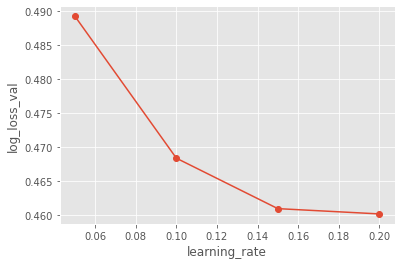

In [ ]:
%%time
# Learning rate
parametros['learning_rate'] = busca_param([0.05, 0.1, 0.15, 0.2], 'learning_rate', parametros)
print(parametros)

  0%|          | 0/3 [00:00<?, ?it/s]

n_estimators=700 log_loss_val=0.4588779323706667
n_estimators=800 log_loss_val=0.4619393538714542
n_estimators=900 log_loss_val=0.4630085833055329
Mejor n_estimators=700 Score=0.4588779323706667
{'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
CPU times: user 55min 56s, sys: 16.1 s, total: 56min 12s
Wall time: 28min 46s


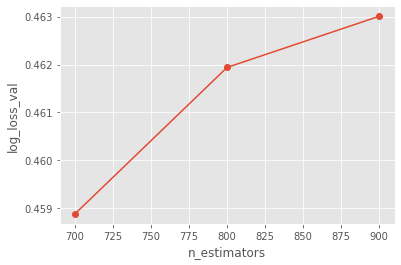

In [ ]:
%%time
# Busqueda del numero de arboles
parametros['n_estimators'] = busca_param(np.arange(700,1000,100), 'n_estimators', parametros)
print(parametros)

  0%|          | 0/4 [00:00<?, ?it/s]

max_depth=6 log_loss_val=0.45963410170450864
max_depth=7 log_loss_val=0.4588779323706667
max_depth=8 log_loss_val=0.4620744201436723
max_depth=9 log_loss_val=0.45932489580420116
Mejor max_depth=7 Score=0.4588779323706667
{'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
CPU times: user 1h 6min 32s, sys: 19.1 s, total: 1h 6min 51s
Wall time: 34min 7s


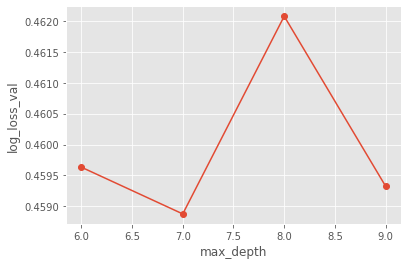

In [ ]:
%%time
# Maxima profundidad
parametros['max_depth'] = busca_param(np.arange(6,10), 'max_depth', parametros)
print(parametros)

  0%|          | 0/5 [00:00<?, ?it/s]

min_child_weight=1 log_loss_val=0.4588779323706667
min_child_weight=0.1 log_loss_val=0.4586348009351462
min_child_weight=10 log_loss_val=0.4645508806177758
min_child_weight=0.5 log_loss_val=0.4618054372892258
min_child_weight=0.01 log_loss_val=0.5089666640450263
Mejor min_child_weight=0.1 Score=0.4586348009351462
{'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 0.1, 'subsample': 1.0, 'subsample_freq': 1, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
CPU times: user 1h 23min 36s, sys: 23.1 s, total: 1h 23min 59s
Wall time: 42min 49s


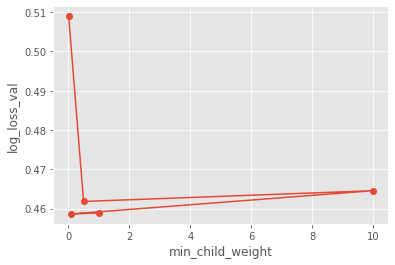

In [ ]:
%%time
# Subsample
parametros['min_child_weight'] = busca_param([1,0.1,10,0.5,0.01], 'min_child_weight', parametros)
print(parametros)

  0%|          | 0/4 [00:00<?, ?it/s]

subsample=0.6 log_loss_val=0.456860883431562
subsample=0.7 log_loss_val=0.45446158576704876
subsample=0.8 log_loss_val=0.4530885232763381
subsample=0.9 log_loss_val=0.45298249843410815
Mejor subsample=0.9 Score=0.45298249843410815
{'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 0.1, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
CPU times: user 1h 6min 46s, sys: 20.6 s, total: 1h 7min 7s
Wall time: 34min 13s


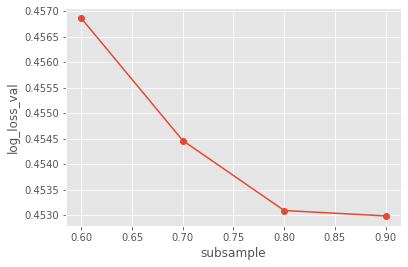

In [ ]:
%%time
# Subsample
parametros['subsample'] = busca_param(np.arange(6,10)/10.0, 'subsample', parametros)
print(parametros)

  0%|          | 0/4 [00:00<?, ?it/s]

colsample_bytree=0.4 log_loss_val=0.45467150897931136
colsample_bytree=0.5 log_loss_val=0.4528236981003701
colsample_bytree=0.6 log_loss_val=0.4564547980419897
colsample_bytree=0.7 log_loss_val=0.4525262148624059
Mejor colsample_bytree=0.7 Score=0.4525262148624059
{'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 0.1, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
CPU times: user 46min 39s, sys: 18.3 s, total: 46min 57s
Wall time: 23min 58s


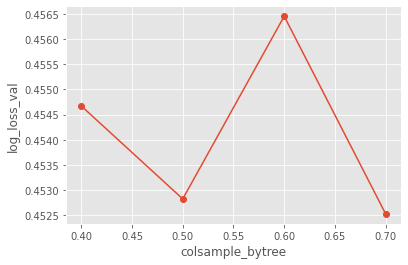

In [ ]:
%%time
# Colsample_bytree
parametros['colsample_bytree'] = busca_param(np.arange(4,8)/10.0, 'colsample_bytree', parametros)
print(parametros)

  0%|          | 0/5 [00:00<?, ?it/s]

min_child_weight=1 log_loss_val=0.45644874887340753
min_child_weight=0.1 log_loss_val=0.4525262148624059
min_child_weight=10 log_loss_val=0.4650363432256358
min_child_weight=0.5 log_loss_val=0.45238656188832566
min_child_weight=0.01 log_loss_val=0.5075479767122903
Mejor min_child_weight=0.5 Score=0.45238656188832566
{'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 0.5, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
CPU times: user 1h 7min 52s, sys: 22.6 s, total: 1h 8min 15s
Wall time: 34min 49s


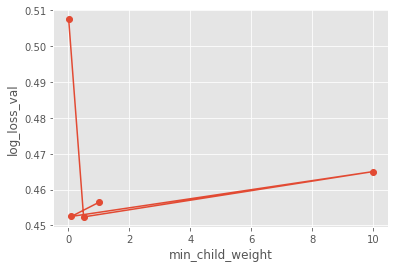

In [ ]:
%%time
# Subsample
parametros['min_child_weight'] = busca_param([1,0.1,10,0.5,0.01], 'min_child_weight', parametros)
print(parametros)

  0%|          | 0/4 [00:00<?, ?it/s]

subsample_freq=0 log_loss_val=0.45882206659898167
subsample_freq=1 log_loss_val=0.45238656188832566
subsample_freq=10 log_loss_val=0.4556277753048349
subsample_freq=60 log_loss_val=0.4580111725571149
Mejor subsample_freq=1 Score=0.45238656188832566
{'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 0.5, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
CPU times: user 54min 18s, sys: 18.5 s, total: 54min 36s
Wall time: 27min 53s


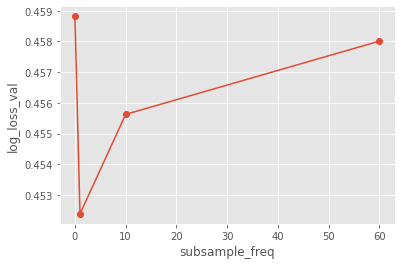

In [ ]:
%%time
# Subsample
parametros['subsample_freq'] = busca_param([0,1,10,60], 'subsample_freq', parametros)
print(parametros)

  0%|          | 0/4 [00:00<?, ?it/s]

reg_alpha=0.0001 log_loss_val=0.45153827567362126
reg_alpha=0.001 log_loss_val=0.45279273769542305
reg_alpha=0.01 log_loss_val=0.454922888633581
reg_alpha=0.1 log_loss_val=0.4548922077809789
Mejor reg_alpha=0.0001 Score=0.45153827567362126
{'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 0.5, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.7, 'reg_alpha': 0.0001, 'reg_lambda': 0.0}
CPU times: user 54min 14s, sys: 19.2 s, total: 54min 33s
Wall time: 27min 51s


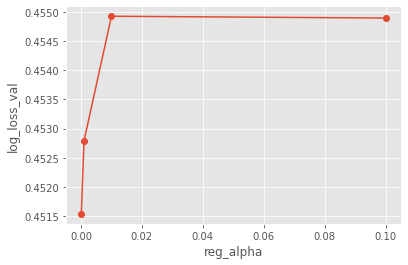

In [ ]:
%%time
# Probamos con Regularización L1
parametros['reg_alpha'] = busca_param([0.0001, 0.001, 0.01, 0.1], 'reg_alpha', parametros)
print(parametros)

In [11]:
parametros

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 400,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_freq': 1}

In [12]:
parametros = {'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 0.5,
 'n_estimators': 700,
 'reg_alpha': 0.0001,
 'reg_lambda': 0.01,
 'subsample': 0.9,
 'subsample_freq': 1}

  0%|          | 0/4 [00:00<?, ?it/s]

reg_lambda=0.01 log_loss_val=0.4530094674060761
reg_lambda=0.1 log_loss_val=0.45309048377300715
reg_lambda=1.0 log_loss_val=0.45417446050877797
reg_lambda=5 log_loss_val=0.45557239345676237
Mejor reg_lambda=0.01 Score=0.4530094674060761
{'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 0.5, 'n_estimators': 700, 'reg_alpha': 0.0001, 'reg_lambda': 0.01, 'subsample': 0.9, 'subsample_freq': 1}
CPU times: user 57min 14s, sys: 17.6 s, total: 57min 32s
Wall time: 29min 21s


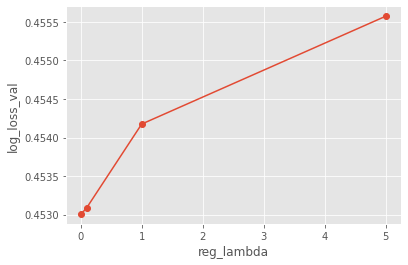

In [13]:
%%time
# Probamos con Regularización L2
parametros['reg_lambda'] = busca_param([0.01, 0.1, 1.0, 5], 'reg_lambda', parametros)
print(parametros)

Submission a kaggle

In [17]:
%%time
lgb_model = LGBMClassifier(learning_rate =0.2, n_estimators=700, max_depth=7, 
                          subsample=0.9, colsample_bytree=0.7, nthread=4,
                          reg_alpha=0.0001, reg_lambda=0.01,subsample_freq= 1, min_child_weight=0.5,
                          seed=42, objective='multi:softprob')
log_loss_val = entrena_model_hold_out(lgb_model, calibra=True)
print(f'Best LGB con local log_loss_val={log_loss_val}')

Best LGB con local log_loss_val=0.45571882393936447
CPU times: user 14min 27s, sys: 4.35 s, total: 14min 31s
Wall time: 7min 32s


In [19]:
%%time
# Creamos submission
calibrated_clf = CalibratedClassifierCV(lgb_model, method='isotonic', cv=5)
calibrated_clf.fit(X, y)
test_preds = calibrated_clf.predict_proba(X_test_scaled)

output = pd.DataFrame(test_preds,columns=["Class_"+str(i) for i in range(1,10)])
output.insert(loc=0, column='id', value=df_test.id)
output.to_csv('submission_lgb.csv', index=False)
pd.read_csv('submission_lgb.csv').head()

CPU times: user 25min 35s, sys: 5.55 s, total: 25min 41s
Wall time: 13min 19s


## ENTREGA

**Todos los pasos realizados deberán ser explicados con detalle en un documento PDF. El nombre del archivo deberá incluir lo siguiente 'PROYECTO3_NombreDelAlumnoSinAcentos.PDF'. Ejemplo: PROYECTO3_PEPITO_PEREZ.PDF**

Si usas Colab, recuerde guardar sus cambios en su repositorio utilizando la opción "Save a copy in GitHub..." del menú File.